# Importing packages for my tree models

In [1]:
# Importing the packages to prepare the mdoel and execute it...
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings


warnings.filterwarnings(action="ignore")

plt.rcParams["figure.figsize"] = (6, 4)

# Loading the case-only dataset
This cell reads the same cleaned dataset you used before.

In [41]:
# Loading all the dataset again and creatign datafile
currentpath = Path.cwd()

# baseTablePath = Path("C:/STS/My Project/StressMetastasis/Aim1/data/analysis_base_clean.csv")
df = pd.read_csv(f'{currentpath.parent}/data/analysis_base_clean.csv')
print(df.columns.tolist())
print("Loaded shape:", df.shape)

['seqn', 'age_years', 'age_group', 'sex', 'race_eth', 'educ_level', 'pir', 'mcq220', 'ever_cancer', 'dpq_total', 'dpq_cat', 'smoke_status', 'hscrp_mg_l_raw', 'hscrp_cat', 'bmx_bmi', 'bmx_weight_kg', 'bmx_height_cm', 'bmx_waist_cm', 'bmx_hip_cm', 'dpq_severity', 'hscrp_flag_acute']
Loaded shape: (7800, 21)


# Selecting cancer cases only and creating the early vs late target

In [3]:
# I was getting an error in the model, so I changed the type to integer 
if "ever_cancer" in df.columns:
    outcome_col = "ever_cancer"
    df[outcome_col] = pd.to_numeric(df[outcome_col], errors="coerce").astype("Int64")
elif "mcq220" in df.columns:
    outcome_col = "mcq220"
    tmp = pd.to_numeric(df[outcome_col], errors="coerce").map({1: 1, 2: 0})
    df[outcome_col] = tmp.astype("Int64")
else:
    raise ValueError("Need a cancer indicator column.")

if "early_onset_proxy" not in df.columns:
    df["early_onset_proxy"] = (pd.to_numeric(df["age_years"], errors="coerce") < 50).astype(int)

cases = df[pd.to_numeric(df[outcome_col], errors="coerce") == 1].copy()
TARGET_COL = "early_onset_proxy"
print("Case-only shape:", cases.shape)

Case-only shape: (1169, 22)


# relevant variables

In [4]:
# make a copy of cases so we can add engineered columns
cases = cases.copy()

# create log CRP if raw CRP exists
if "hscrp_mg_l_raw" in cases.columns:
    cases["log_hscrp"] = np.log1p(cases["hscrp_mg_l_raw"])  # log(1+x) to avoid log(0)
else:
    cases["log_hscrp"] = np.nan

# numeric features that EXIST in your df
num_features = [c for c in [
    "dpq_total",      # depression score
    "log_hscrp",      # hscrp_mg_l_raw
    "pir",            # income ratio
    "age_years",
    "bmx_bmi"         # BMI column
] if c in cases.columns]

# categorical features that EXIST
cat_features = [c for c in [
    "smoke_status",
    "sex",
    "educ_level",
    "race_eth"
] if c in cases.columns]

# build encoded dataframe
cases_enc = pd.get_dummies(
    cases[num_features + cat_features + [TARGET_COL]],
    drop_first=True
)

X = cases_enc.drop(columns=[TARGET_COL])
y = cases_enc[TARGET_COL]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Numeric features: ['dpq_total', 'log_hscrp', 'pir', 'age_years', 'bmx_bmi']
Categorical features: ['smoke_status', 'sex', 'educ_level', 'race_eth']
Final X shape: (1169, 10)
Final y shape: (1169,)


# Splits the dataset for training and evaluation.

In [5]:
X.drop(columns='age_years', inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (818, 9) Test: (351, 9)


# fiting the Random Forest model

In [7]:
# Random forest model :-)
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("Random Forest trained.")

Random Forest trained.


# fFts the XGBoost model with the parameters your professor suggested.

In [8]:
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)
xgb_model.fit(X_train, y_train)
print("XGBoost trained.")

XGBoost trained.


# accuracy/AUC and saving ROC plots for both models

Random Forest Accuracy: 0.923
Random Forest AUC: 0.652


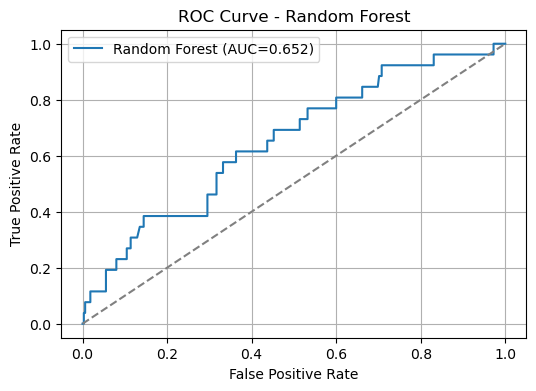

Saved ROC to roc_random_forest.png
XGBoost Accuracy: 0.915
XGBoost AUC: 0.557


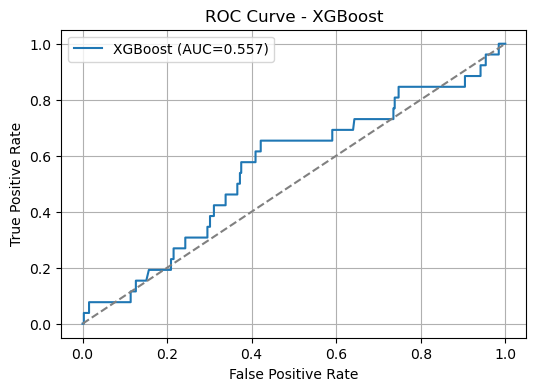

Saved ROC to roc_xgboost.png


In [9]:
def evaluate_model(model, X_test, y_test, model_name="model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{model_name} Accuracy: {acc:.3f}")
    print(f"{model_name} AUC: {auc:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    fname = f"roc_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved ROC to", fname)

evaluate_model(rf, X_test, y_test, model_name="Random Forest")
evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")

#  variables which contributed the most.

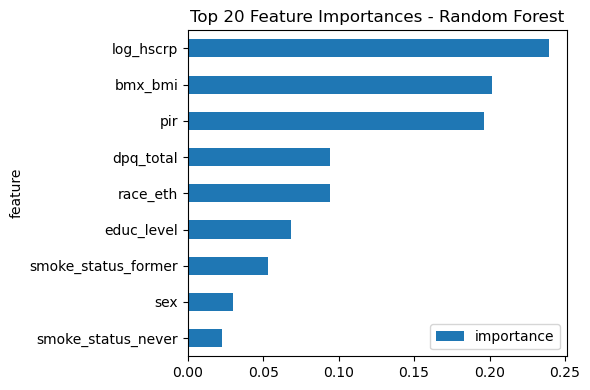

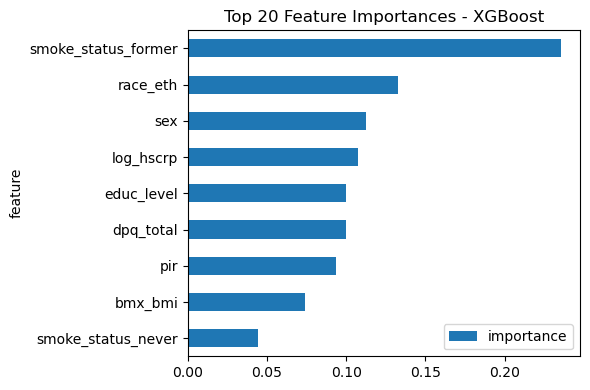

In [10]:
def plot_feature_importance(importances, feature_names, model_name="model", top_n=20):
    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).head(top_n)

    fi.plot(kind="barh", x="feature", y="importance")
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()
    return fi

rf_fi = plot_feature_importance(rf.feature_importances_, X_train.columns, model_name="Random Forest")
xgb_fi = plot_feature_importance(xgb_model.feature_importances_, X_train.columns, model_name="XGBoost")

# SHAP for XGBoost

ExactExplainer explainer: 819it [00:16, 20.98it/s]                                                                      


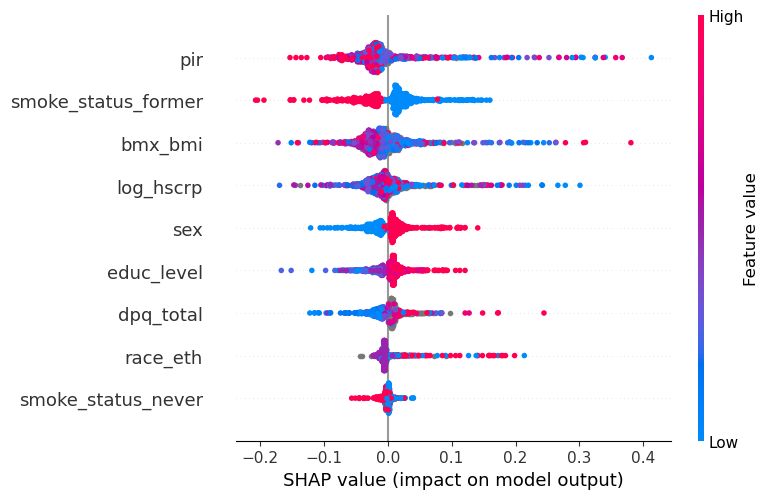

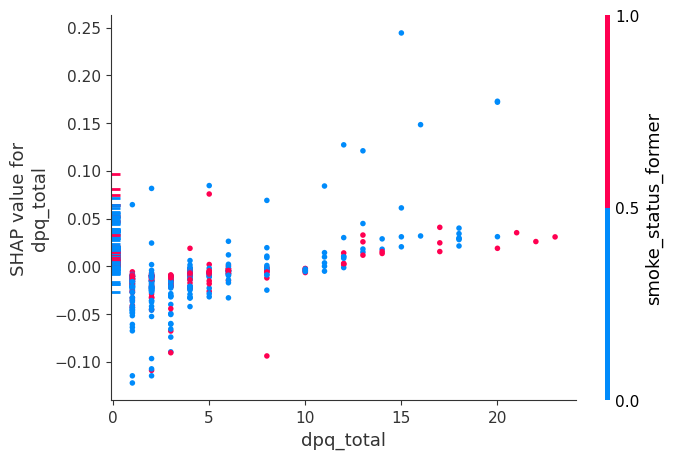

In [11]:
X_train_num = X_train.astype(float)
X_test_num = X_test.astype(float)

background = X_train_num.sample(200, random_state=42)

predict_fn = lambda X: xgb_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(predict_fn, background)
shap_values = explainer(X_train_num)

shap.summary_plot(shap_values.values, X_train_num, show=False)
plt.savefig("shap_summary_xgboost.png", dpi=150, bbox_inches="tight")
plt.show()

PHQ_COL = "dpq_total"
if PHQ_COL in X_train_num.columns:
    shap.dependence_plot(PHQ_COL, shap_values.values, X_train_num, show=False)
    plt.savefig("shap_dependence_dpq_total_std.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print(f"{PHQ_COL} not found in columns.")

### Mukesh Updated code to check

In [12]:
noncases = df[df['ever_cancer']==0]
cases.drop(columns=['bmx_weight_kg','bmx_height_cm', 'bmx_waist_cm', 'bmx_hip_cm'], inplace = True)

In [13]:

cases['stress_high'] = cases['dpq_cat'].isin(['moderate','mod-severe','severe']).astype(int)

pd.crosstab(cases['early_onset_proxy'], cases['stress_high'], normalize='index')


stress_high,0,1
early_onset_proxy,,
0,0.930684,0.069316
1,0.896552,0.103448


In [14]:
noncases['stress_high'] = noncases['dpq_cat'].isin(['moderate','mod-severe','severe']).astype(int)
pd.crosstab(noncases['early_onset_proxy'], noncases['stress_high'], normalize='index')

stress_high,0,1
early_onset_proxy,,
0,0.928452,0.071548
1,0.894702,0.105298


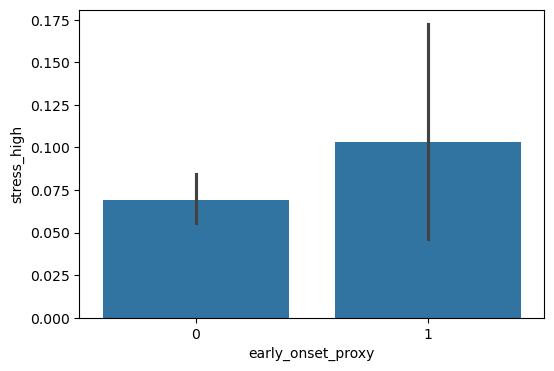

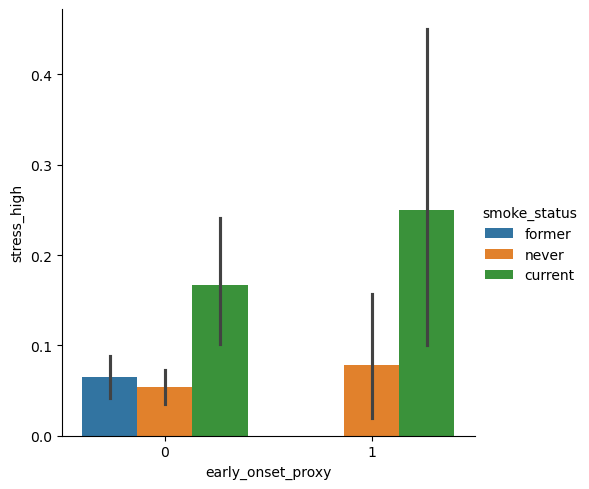

In [15]:
sns.barplot(x='early_onset_proxy', y='stress_high', data=cases, ci=95)
sns.catplot(x='early_onset_proxy', y='stress_high', hue='smoke_status', data=cases, kind='bar')


In [16]:

cases = cases[cases['hscrp_flag_acute'] != 1]
X = cases[['sex','race_eth','educ_level','pir','smoke_status','bmx_bmi','log_hscrp','hscrp_cat','early_onset_proxy']]
y = cases['stress_high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(774, 9) (332, 9)


In [17]:
print("y_train counts:")
print(y_train.value_counts())

neg, pos = np.bincount(y_train)   
ratio = neg / pos
print("neg:", neg, "pos:", pos, "ratio (neg/pos):", ratio)

y_train counts:
stress_high
0    719
1     55
Name: count, dtype: int64
neg: 719 pos: 55 ratio (neg/pos): 13.072727272727272


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_cols = ['pir', 'bmx_bmi', 'log_hscrp', 'early_onset_proxy','sex','race_eth','educ_level']
cat_cols = ['smoke_status', 'hscrp_cat']

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

In [19]:
preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['pir', 'bmx_bmi', 'log_hscrp',
                                  'early_onset_proxy', 'sex', 'race_eth',
                                  'educ_level']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['smoke_status', 'hscrp_cat'])])

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        random_state=42,
        class_weight="balanced_subsample"    
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print("AUC:", roc_auc_score(y_test, y_proba_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
AUC: 0.6921345152666385
Accuracy: 0.8644578313253012
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       309
           1       0.00      0.00      0.00        23

    accuracy                           0.86       332
   macro avg       0.46      0.46      0.46       332
weighted avg       0.86      0.86      0.86       332



### Balanced Random Forest

In [21]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = Pipeline([
    ('pre', preprocessor),
    ('clf', BalancedRandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        sampling_strategy='auto',
        random_state=42
    ))
])

brf.fit(X_train, y_train)
y_pred_rf = brf.predict(X_test)
y_proba_rf = brf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print("AUC:", roc_auc_score(y_test, y_proba_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
AUC: 0.7299845223019558
Accuracy: 0.6867469879518072
              precision    recall  f1-score   support

           0       0.97      0.69      0.80       309
           1       0.14      0.70      0.24        23

    accuracy                           0.69       332
   macro avg       0.55      0.69      0.52       332
weighted avg       0.91      0.69      0.76       332



### XGBoost with SMOTE

In [22]:
smote = SMOTE(random_state=42)

xgb = ImbPipeline([
    ('pre', preprocessor),
    ('smote', smote),                    
    ('clf', XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc',
        scale_pos_weight=1           
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print("AUC:", roc_auc_score(y_test, y_proba_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


=== XGBoost ===
AUC: 0.6269874771352187
Accuracy: 0.8885542168674698
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       309
           1       0.00      0.00      0.00        23

    accuracy                           0.89       332
   macro avg       0.46      0.48      0.47       332
weighted avg       0.86      0.89      0.88       332



### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

logit = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        max_iter=200
    ))
])

logit.fit(X_train, y_train)
y_pred_log = logit.predict(X_test)
y_proba_log = logit.predict_proba(X_test)[:,1]

In [24]:
print("=== Logistic ===")
print("AUC:", roc_auc_score(y_test, y_proba_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

=== Logistic ===
AUC: 0.7339242999859293
Accuracy: 0.6867469879518072
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       309
           1       0.13      0.61      0.21        23

    accuracy                           0.69       332
   macro avg       0.54      0.65      0.51       332
weighted avg       0.90      0.69      0.76       332



<Figure size 600x500 with 0 Axes>

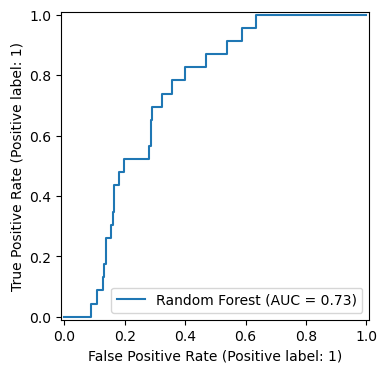

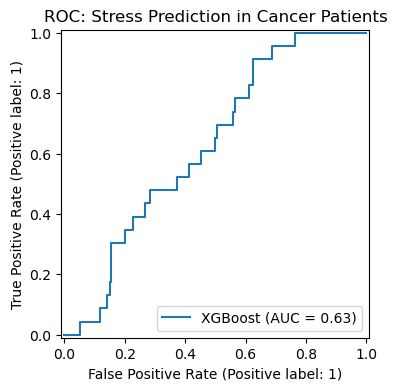

In [25]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_proba_rf, name='Random Forest')
RocCurveDisplay.from_predictions(y_test, y_proba_xgb, name='XGBoost')
plt.title("ROC: Stress Prediction in Cancer Patients")
plt.savefig("roc_stress_models.png", dpi=200)
plt.show()


shap_exp.values.shape: (774, 13, 2)
(774, 13)
(774, 13)
13


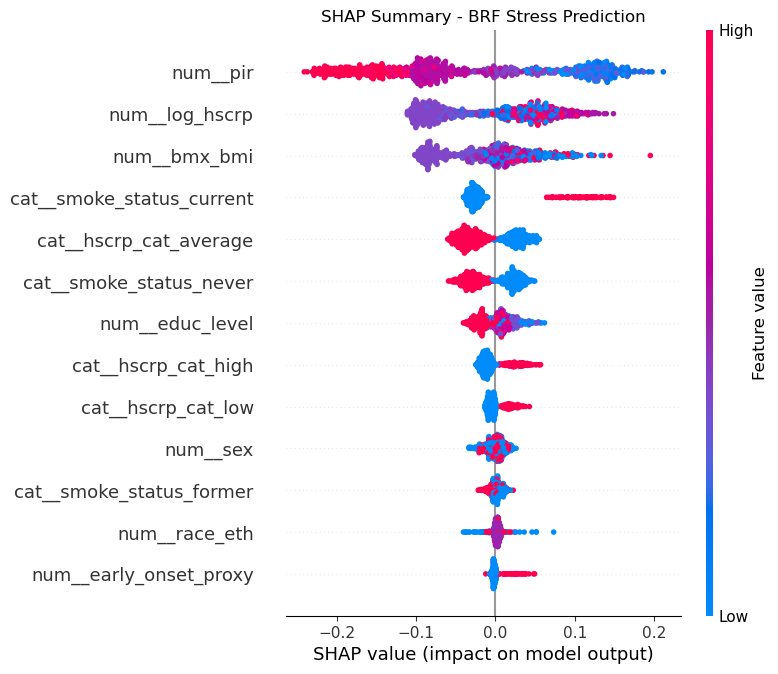

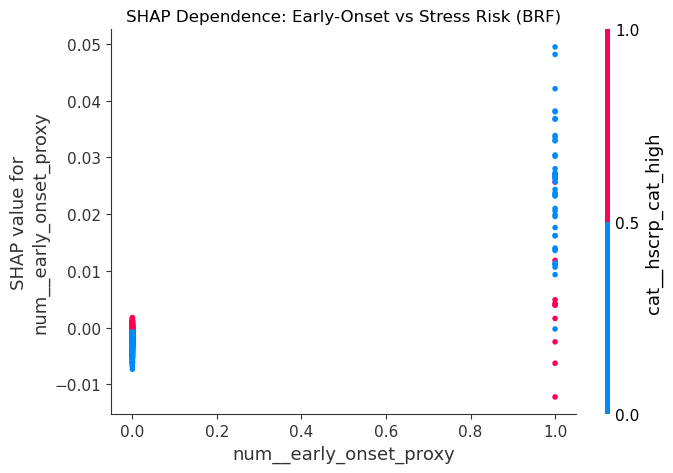

In [38]:
import shap
import matplotlib.pyplot as plt
import numpy as np

enc = brf.named_steps['pre']
clf = brf.named_steps['clf']

X_train_enc = enc.transform(X_train)
if hasattr(X_train_enc, "toarray"): 
    X_train_enc = X_train_enc.toarray()

feature_names = enc.get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_exp = explainer(X_train_enc) 

print("shap_exp.values.shape:", shap_exp.values.shape)

vals = shap_exp.values

if vals.ndim == 3:
    shap_values_pos = vals[:, :, 1]
else:
    shap_values_pos = vals

print(shap_values_pos.shape)
print(X_train_enc.shape)
print(len(feature_names))

shap.summary_plot(
    shap_values_pos,
    X_train_enc,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary - BRF Stress Prediction")
plt.show()

idx = list(feature_names).index('num__early_onset_proxy')

shap.dependence_plot(
    idx,
    shap_values_pos,
    X_train_enc,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Dependence: Early-Onset vs Stress Risk (BRF)")
plt.show()

The model identified low income, high inflammation, higher BMI, and current smoking as the main drivers of stress. Early-onset cancer still contributes positively, even after accounting for these factors — meaning younger patients are more likely to have higher stress.

X_test_enc shape: (332, 13)
len(feature_names): 13
shap_exp_test.values.shape: (332, 13, 2)
shap_values_pos_test shape: (332, 13)


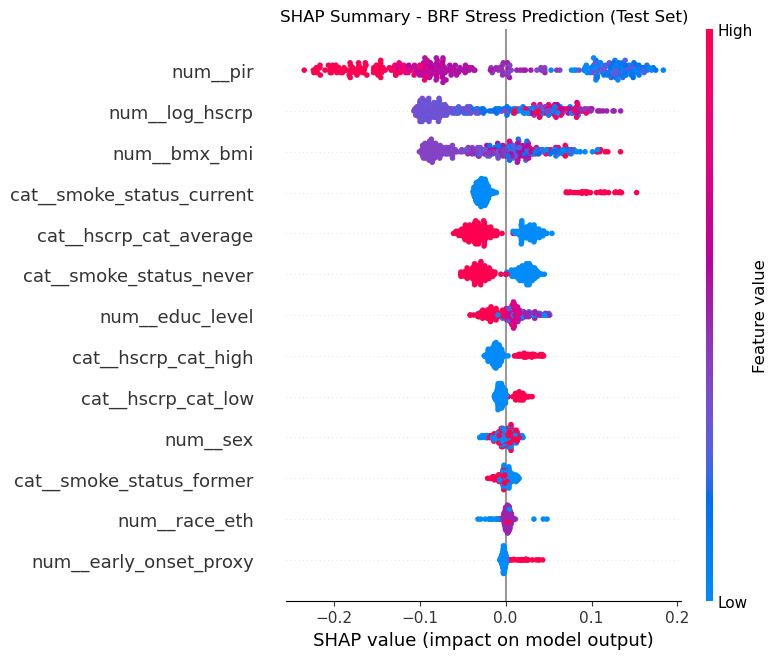

In [39]:

X_test_enc = enc.transform(X_test)
if hasattr(X_test_enc, "toarray"):  # handle sparse matrix
    X_test_enc = X_test_enc.toarray()

print("X_test_enc shape:", X_test_enc.shape)
print("len(feature_names):", len(feature_names))

shap_exp_test = explainer(X_test_enc)
vals = shap_exp_test.values
print("shap_exp_test.values.shape:", vals.shape)

if vals.ndim == 3:
    shap_values_pos_test = vals[:, :, 1]
else:
    shap_values_pos_test = vals

print("shap_values_pos_test shape:", shap_values_pos_test.shape)

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_pos_test,
    X_test_enc,
    feature_names=feature_names,
    show=False,
    plot_type="dot"
)
plt.title("SHAP Summary - BRF Stress Prediction (Test Set)")
plt.tight_layout()
plt.show()
